<a href="https://colab.research.google.com/github/SachinRavi1607/AI_DermaScan/blob/main/dermaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import shutil

# --- 1. EXTRACT ---
zip_path = '/content/archive (7).zip'
extract_path = '/content/dataset'

# Clean previous data
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

if os.path.exists(zip_path):
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("❌ Error: File not found. Please upload 'Dermal_Skin_dataset.zip' to the Files sidebar.")

# --- 2. AUTO-FIND PATH ---
# This finds the folder containing your classes, no matter how deep it is
base_dir = None
for root, dirs, files in os.walk(extract_path):
    if 'normal' in dirs and 'wrinkles' in dirs:
        base_dir = root
        break

if base_dir:
    print(f"✅ Dataset successfully found at: {base_dir}")
else:
    print("❌ Error: Could not find class folders (normal, wrinkles) inside the zip.")

Extracting /content/archive (7).zip...
✅ Dataset successfully found at: /content/dataset/archive (7)/dermal_Skin_dataset


In [ ]:
from google.colab import drive
import os

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Create a folder for your project if it doesn't exist
project_path = '/content/drive/MyDrive/DermalScan_Project'
if not os.path.exists(project_path):
    os.makedirs(project_path)
    print(f"Created project folder at: {project_path}")
else:
    print(f"Project folder exists at: {project_path}")

# 3. Move your dataset there (Run this ONLY ONCE if you haven't moved it yet)
# This copies your current extracted dataset to the permanent Drive folder
source_data = '/content/dataset' # Where we extracted it earlier
dest_data = os.path.join(project_path, 'dataset')

import shutil
if os.path.exists(source_data) and not os.path.exists(dest_data):
    print("Copying dataset to Drive (this helps reuse it later)...")
    shutil.copytree(source_data, dest_data)
    print("Dataset saved to Drive!")
else:
    print("Dataset is already on Drive or source not found.")

# Update base_dir to point to the DRIVE location now
base_dir = dest_data
print(f"✅ working with data from: {base_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project folder exists at: /content/drive/MyDrive/DermalScan_Project
Dataset is already on Drive or source not found.
✅ working with data from: /content/drive/MyDrive/DermalScan_Project/dataset


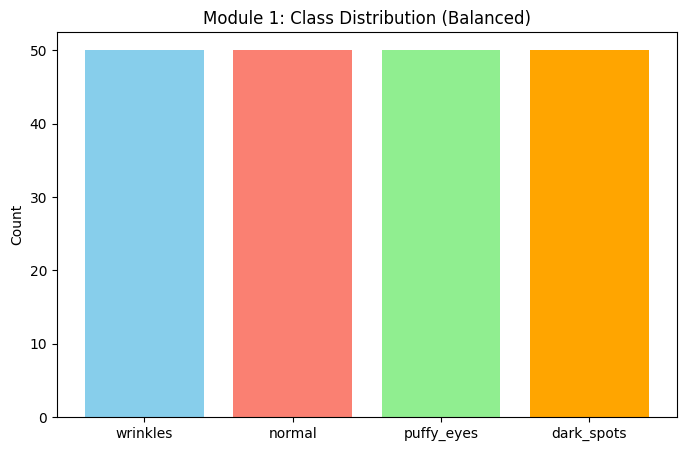

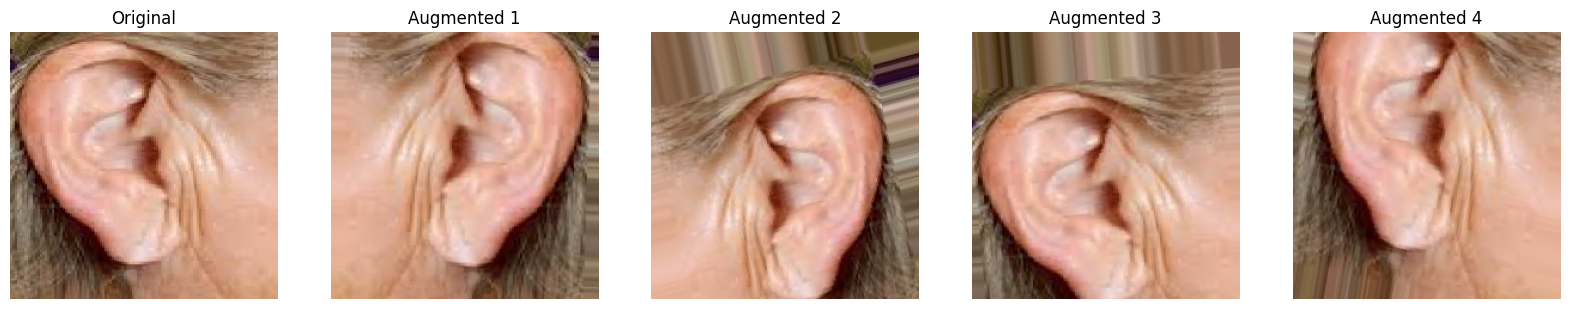

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import os

# --- CHART 1: CLASS BALANCE ---
class_counts = {}
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon', 'lightgreen', 'orange'])
plt.title('Module 1: Class Distribution (Balanced)')
plt.ylabel('Count')
plt.show()

# --- CHART 2: AUGMENTATION SAMPLES ---
datagen_viz = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pick one random image to show augmentation
target_class = list(class_counts.keys())[0]
img_name = os.listdir(os.path.join(base_dir, target_class))[0]
img_path = os.path.join(base_dir, target_class, img_name)

img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis('off')

i = 1
for batch in datagen_viz.flow(x, batch_size=1):
    axes[i].imshow(batch[0].astype('uint8'))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')
    i += 1
    if i >= 5: break
plt.show()

In [ ]:

!pip install mediapipe==0.10.13


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image
import mediapipe as mp
import io
import csv

# ================= CONFIGURATION =================
MODEL_PATH = "/content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5"

CLASS_NAMES = {
    0: "Dark Spots",
    1: "Normal Skin",
    2: "Puffy Eyes",
    3: "Wrinkles"
}

st.set_page_config(
    page_title="DermalScan AI",
    page_icon="🧬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# ================= CUSTOM STYLING (CSS) =================
st.markdown("""
<style>
    /* Main Background & Text */
    .main {
        background-color: #0E1117;
    }
    h1 {
        color: #00ADB5;
        font-family: 'Helvetica Neue', sans-serif;
        font-weight: 800;
    }
    h3 {
        color: #EEEEEE;
    }

    /* Glassmorphism Card Style */
    .glass-card {
        background: rgba(22, 27, 34, 0.8);
        border: 1px solid rgba(48, 54, 61, 0.5);
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.3);
        border-radius: 15px;
        padding: 20px;
        margin-bottom: 20px;
        backdrop-filter: blur(10px);
        transition: transform 0.2s;
    }
    .glass-card:hover {
        border-color: #00ADB5;
        transform: translateY(-2px);
    }

    /* Status Badges */
    .badge-success {
        background-color: #0f5132;
        color: #d1e7dd;
        padding: 5px 10px;
        border-radius: 12px;
        font-size: 12px;
        font-weight: bold;
    }
    .badge-warning {
        background-color: #664d03;
        color: #fff3cd;
        padding: 5px 10px;
        border-radius: 12px;
        font-size: 12px;
        font-weight: bold;
    }

    /* Primary Prediction Highlight */
    .primary-pred {
        font-size: 24px;
        font-weight: bold;
        color: #00ADB5;
        margin-bottom: 10px;
    }
</style>
""", unsafe_allow_html=True)

# ================= LOAD MODEL =================
@st.cache_resource
def load_model():
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        return model
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None

model = load_model()

# ================= MEDIAPIPE =================
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.3)

# ================= HELPERS =================
def is_face_large_enough(bbox, img_w, img_h, min_ratio=0.005):
    return ((bbox.width * img_w) * (bbox.height * img_h)) / (img_w * img_h) >= min_ratio

def expand_bbox(x1, y1, x2, y2, img_w, img_h, scale=0.20):
    w, h = x2 - x1, y2 - y1
    x1 = max(0, int(x1 - w * scale))
    y1 = max(0, int(y1 - h * scale))
    x2 = min(img_w, int(x2 + w * scale))
    y2 = min(img_h, int(y2 + h * scale))
    return x1, y1, x2, y2

def check_if_skin(image_array):
    hsv = cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([25, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_skin, upper_skin)
    return (np.count_nonzero(mask) / mask.size) * 100 > 30

# ================= SIDEBAR =================
with st.sidebar:
    st.image("https://cdn-icons-png.flaticon.com/512/3004/3004458.png", width=80)
    st.title("Control Panel")
    st.info("Upload a patient image to begin analysis.")
    uploaded_file = st.file_uploader("Choose Image", type=["jpg", "jpeg", "png"])
    st.markdown("---")
    st.markdown("**Version:** 2.0 Pro")
    st.markdown("**Status:** System Online 🟢")

# ================= MAIN LAYOUT =================
st.markdown("<h1>🧬 DermalScan AI <span style='font-size:20px; color:#666'>| Clinical Analysis System</span></h1>", unsafe_allow_html=True)

if uploaded_file is None:
    st.markdown("""
    <div class='glass-card' style='text-align:center; padding:50px;'>
        <h3>👋 Welcome to DermalScan</h3>
        <p style='color:#888;'>Upload a facial image or skin close-up using the sidebar to generate a diagnostic report.</p>
    </div>
    """, unsafe_allow_html=True)

# ================= ANALYSIS LOGIC =================
elif model is not None:
    # 1. Load Image
    image = Image.open(uploaded_file)
    img = np.array(image)
    if img.shape[-1] == 4: img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    annotated = img.copy()

    # 2. Pipeline
    detections = face_detector.process(rgb).detections
    results = []

    # PATH A: Faces
    if detections:
        valid_faces = []
        for i, det in enumerate(detections, start=1):
            bbox = det.location_data.relative_bounding_box
            if is_face_large_enough(bbox, w, h):
                valid_faces.append((f"Face {i}", bbox))

        if valid_faces:
            for face_id, bbox in valid_faces:
                x1, y1, x2, y2 = expand_bbox(int(bbox.xmin * w), int(bbox.ymin * h),
                                           min(w, int(bbox.xmin * w) + int(bbox.width * w)),
                                           min(h, int(bbox.ymin * h) + int(bbox.height * h)), w, h)
                crop_bgr = img[y1:y2, x1:x2]
                if crop_bgr.size == 0: continue

                cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 255), 3) # Cyan box
                cv2.putText(annotated, face_id, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                roi = cv2.resize(crop_bgr, (224, 224))
                preds = model.predict(np.expand_dims(roi, axis=0), verbose=0)[0]
                results.append((face_id, {CLASS_NAMES[i]: float(preds[i] * 100) for i in range(4)}, "FACE DETECTED"))

    # PATH B: Skin Texture
    if not results:
        if check_if_skin(img):
            roi = cv2.resize(img, (224, 224))
            preds = model.predict(np.expand_dims(roi, axis=0), verbose=0)[0]
            results.append(("Macro Analysis", {CLASS_NAMES[i]: float(preds[i] * 100) for i in range(4)}, "TEXTURE MODE"))
            cv2.rectangle(annotated, (0, 0), (w, h), (0, 255, 0), 5)
        else:
            st.error("❌ Invalid Image: No human face or skin texture detected.")
            st.stop()

    # ================= DASHBOARD DISPLAY =================
    col_img, col_data = st.columns([1, 1.3], gap="large")

    with col_img:
        st.markdown("<div class='glass-card'>", unsafe_allow_html=True)
        st.subheader("📸 Scan Input")
        st.image(annotated, use_column_width=True, channels="RGB")

        # Download Buttons
        res_img = Image.fromarray(annotated)
        buf = io.BytesIO()
        res_img.save(buf, format="JPEG")
        st.download_button("⬇️ Download Annotated Scan", buf.getvalue(), "scan_result.jpg", "image/jpeg", use_container_width=True)
        st.markdown("</div>", unsafe_allow_html=True)

    with col_data:
        for face_id, probs, mode in results:
            # Dynamic Badge Color
            badge_class = "badge-success" if mode == "FACE DETECTED" else "badge-warning"

            st.markdown(f"""
            <div class='glass-card'>
                <div style='display:flex; justify-content:space-between; align-items:center;'>
                    <h3>👤 {face_id}</h3>
                    <span class='{badge_class}'>{mode}</span>
                </div>
                <hr style='border-color:#333; margin:10px 0;'>
            """, unsafe_allow_html=True)

            # Primary Prediction
            top_condition = max(probs, key=probs.get)
            top_conf = probs[top_condition]

            st.markdown(f"""
            <div style='margin-bottom:15px;'>
                <span style='color:#888; font-size:14px;'>Primary Diagnosis</span><br>
                <div class='primary-pred'>{top_condition} <span style='font-size:18px; opacity:0.8;'>({top_conf:.1f}%)</span></div>
            </div>
            """, unsafe_allow_html=True)

            # Bar Chart
            st.caption("Complete Confidence Profile")
            st.bar_chart(probs, color="#00ADB5", height=200)

            st.markdown("</div>", unsafe_allow_html=True)

            # CSV Logic
            csv_buf = io.StringIO()
            writer = csv.writer(csv_buf)
            writer.writerow(["ID", "Condition", "Confidence"])
            for k, v in probs.items():
                writer.writerow([face_id, k, f"{v:.2f}%"])

            st.download_button(f"📄 Download Report CSV", csv_buf.getvalue(), f"report_{face_id}.csv", "text/csv", key=face_id)

Overwriting app.py


In [ ]:
# 1. Install Streamlit
!pip install -q streamlit

# 2. Download Cloudflare Tunnel
!wget -q -O cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared

# 3. Run Streamlit in the background
import subprocess
subprocess.Popen(["streamlit", "run", "app.py"])

# 4. Start the Tunnel
import time
print("⏳ Starting App... Please wait 10 seconds...")
time.sleep(10)
print("🚀 Click the link below to open your app:")
!./cloudflared tunnel --url http://localhost:8501

⏳ Starting App... Please wait 10 seconds...
🚀 Click the link below to open your app:
2025-12-23T18:34:11Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-23T18:34:11Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-23T18:34:15Z INF +--------------------------------------------------------------------------------------------+
2025-12-23T18:34:15Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):

In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# --- CONFIGURATION ---
base_dir = '/content/drive/MyDrive/DermalScan_Project/dataset'
valid_classes = ['wrinkles', 'normal', 'dark_spots', 'puffy_eyes']

print("🧹 CLEANUP IN PROGRESS...")
# Check what folders exist
if os.path.exists(base_dir):
    all_folders = os.listdir(base_dir)
    print(f"Current folders found: {all_folders}")

    for folder in all_folders:
        folder_path = os.path.join(base_dir, folder)
        # If it's a folder but NOT one of our 4 skin classes, delete it
        if os.path.isdir(folder_path) and folder not in valid_classes:
            print(f"❌ Removing intruder folder: {folder}")
            shutil.rmtree(folder_path)
        elif not os.path.isdir(folder_path):
             # Remove random files if any exist
             os.remove(folder_path)

print("✅ Cleanup complete. Checking classes again...")

# --- VERIFY & TRAIN ---
train_datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest', validation_split=0.2
)

# Load Data
train_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=16,
    class_mode='sparse', subset='training'
)
val_generator = train_datagen.flow_from_directory(
    base_dir, target_size=(224, 224), batch_size=16,
    class_mode='sparse', subset='validation'
)

# Final Check
if train_generator.num_classes == 4:
    print(f"✅ SUCCESS! Found exactly 4 classes: {list(train_generator.class_indices.keys())}")

    # --- RE-TRAIN ---
    print("\nStarting Training...")
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-20]: layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('/content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5',
                                 monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[checkpoint], verbose=1)
    print("\n🎉 Model Fixed & Saved! You can now run the App.")

else:
    print(f"⚠️ Still found {train_generator.num_classes} classes: {list(train_generator.class_indices.keys())}")
    print("Please manually check your Google Drive folder and delete any extra folders.")

🧹 CLEANUP IN PROGRESS...
Current folders found: ['archive (7)', 'wrinkles', 'normal', 'puffy_eyes', 'dark_spots']
❌ Removing intruder folder: archive (7)
✅ Cleanup complete. Checking classes again...
Found 160 images belonging to 4 classes.
Found 40 images belonging to 4 classes.
✅ SUCCESS! Found exactly 4 classes: ['dark_spots', 'normal', 'puffy_eyes', 'wrinkles']

Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4557 - loss: 1.2908
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to /content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4540 - loss: 1.2901 - val_accuracy: 0.4500 - val_loss: 1.2092
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6639 - loss: 1.0239
Epoch 2: val_accuracy improved from 0.45000 to 0.55000, saving model to /content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.6683 - loss: 1.0188 - val_accuracy: 0.5500 - val_loss: 1.0960
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.7496 - loss: 0.8695
Epoch 3: val_accuracy improved from 0.55000 to 0.62500, saving model to /content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.7513 - loss: 0.8632 - val_accuracy: 0.6250 - val_loss: 0.9007
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8466 - loss: 0.6725
Epoch 4: val_accuracy improved from 0.62500 to 0.72500, saving model to /content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.8481 - loss: 0.6688 - val_accuracy: 0.7250 - val_loss: 0.7816
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8970 - loss: 0.5113
Epoch 5: val_accuracy improved from 0.72500 to 0.77500, saving model to /content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.8927 - loss: 0.5160 - val_accuracy: 0.7750 - val_loss: 0.7272
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8894 - loss: 0.4547
Epoch 6: val_accuracy improved from 0.77500 to 0.82500, saving model to /content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - accuracy: 0.8903 - loss: 0.4559 - val_accuracy: 0.8250 - val_loss: 0.6810
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8659 - loss: 0.4419
Epoch 7: val_accuracy did not improve from 0.82500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.8667 - loss: 0.4410 - val_accuracy: 0.7000 - val_loss: 0.6533
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8925 - loss: 0.3724
Epoch 8: val_accuracy improved from 0.82500 to 0.90000, saving model to /content/drive/MyDrive/DermalScan_Project/best_dermal_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 568ms/step - accuracy: 0.8926 - loss: 0.3724 - val_accuracy: 0.9000 - val_loss: 0.5773
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8138 - loss: 0.4444
Epoch 9: val_accuracy did not improve from 0.90000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.8188 - loss: 0.4400 - val_accuracy: 0.9000 - val_loss: 0.4571
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8769 - loss: 0.3823
Epoch 10: val_accuracy did not improve from 0.90000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.8773 - loss: 0.3843 - val_accuracy: 0.8750 - val_loss: 0.5258
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9612 - loss: 0.2260
Epoch 11: val_accuracy did not improve from 0.90000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 419ms/step - accuracy: 0.9596 - loss: 0.2300 - val_accuracy: 0.8000 - val_loss: 0.5774
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9243 - loss: 0.3062
Epoch 12: val_accuracy did not

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 644ms/step - accuracy: 0.9584 - loss: 0.1471 - val_accuracy: 0.9250 - val_loss: 0.3997
Epoch 18/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9343 - loss: 0.2146
Epoch 18: val_accuracy did not improve from 0.92500
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.9357 - loss: 0.2112 - val_accuracy: 0.9000 - val_loss: 0.3332
Epoch 19/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9728 - loss: 0.1355
Epoch 19: val_accuracy did not improve from 0.92500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.9741 - loss: 0.1327 - val_accuracy: 0.8000 - val_loss: 0.5571
Epoch 20/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9684 - loss: 0.1230
Epoch 20: val_accuracy did not improve from 0.92500
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - accuracy: 0.9690 - loss: 0.1227 - val_accuracy: 0.8000 - val_loss: 0.4642

🎉 Model Fixed & Saved! You can now run the App.
